In [22]:
# External libs
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import importlib

# My modules (must be in the same folder of main.ipynb)
import autoregressiveFunctions as ar
import statFunctions as stat

In [23]:
importlib.reload(ar) # if autoregressiveFunctions.py is modified 
importlib.reload(stat) # if statFunctions.py is modified 

<module 'statFunctions' from 'c:\\Users\\alber\\python_projects\\fundamentals_of_interest_rates\\statFunctions.py'>

# Autoregressive (AR) Processes

An autoregressive (AR) process is a type of time series model where the current value of the series depends linearly on its past values and a random shock (innovation). 

#### General AR(p)
A general AR(p) process depends on the last \(p\) lags:

$$
y_t = a_0 + a_1 y_{t-1} + a_2 y_{t-2} + \dots + a_p y_{t-p} + \varepsilon_t
$$

- The order \(p\) indicates how many past values influence the current value. 

- $a_0$ is a constant term  
- $a_1$ is an autoregressive coefficient  
- $\varepsilon_t$ is a white noise error term





In [24]:
a = np.array([0.1, -0.5, 0.3, 0.4, -0.2])
p = a.size -1

data = ar.generate_ar(steps=1000, paths=4, a=a, start=0, dist='t', error_var=1, degree_f=6)

100%|██████████| 996/996 [00:00<00:00, 83083.61it/s]

4 different AR(4) processes of 998 steps have been generated with increments following t distribution


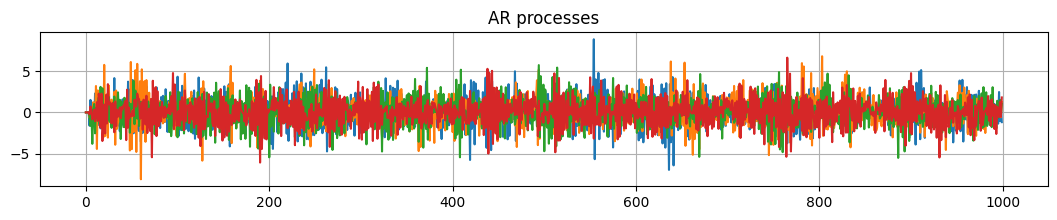

In [25]:
ar.plot_paths(data, size=(13,2))

### Stationarity

In general, an AR(p) is stationary if the roots of the characteristic polynomial lie outside the unit circle.

For an autoregressive process AR(p), the characteristic polynomial is defined as:

$$
\phi(z) = 1 - a_1 z - a_2 z^2 - \dots - a_p z^p
$$

So, it is stationary if:

$$
|z_i| > 1 \quad \forall i
$$

This condition ensures that the effect of past shocks decays over time and the process does not diverge.

As a consequence, we have that:

1. The **mean** is constant:

$$
\mathbb{E}[y_t] = \frac{a_0}{1 - a_1 - \dots - a_p}
$$

2. The **variance** is finite and constant (this formula is for AR(1) only, for p>1 we need to solve Yule-Walker system):

$$
\mathrm{Var}(y_t) = \frac{\sigma^2}{1 - a_1^2}
$$

3. The **autocovariance** depends only on the lag \(k\):

$$
\gamma_k = \mathrm{Cov}(y_t, y_{t-k})
$$

Let's check this facts empirically

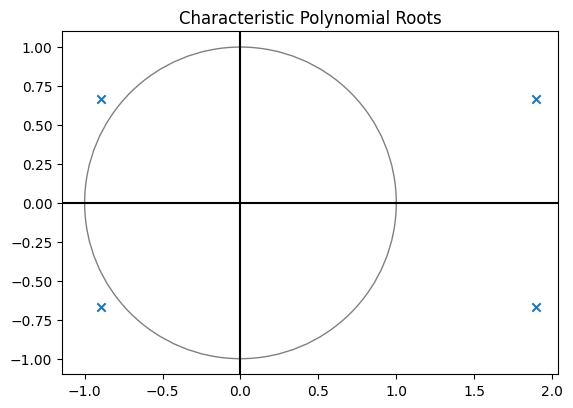

The process is stationary!


In [5]:
roots = ar.characteristic_poly_roots(a, show_plot=True)

if np.all((np.absolute(roots)) > 1):
    print('The process is stationary!')
else:
    print('The process is not stationary')

First of all let's generate many simulations with an increasing # of steps.

In [6]:
steps_list = [100, 1_000, 10_000, 100_000, 1_000_000]

simulations = ar.iterate_simulations(steps_list, paths=1, a=a, error_var=1)

Now let's check if increasing the # of steps we see a convergence of the sample mean toward the theoretical mean

In [7]:
theoretic_mean = (a[0]/(1 - np.sum(a[1:])))
sample_means = [np.mean(sim, axis=0).mean() for sim in simulations.values()]

result = df({'steps': steps_list,'sample_mean': sample_means})
result['sample_mean'] = result['sample_mean'].round(6)

result = pd.concat([result, df({'steps': ['theoretical'], 'sample_mean': [round(theoretic_mean, 6)]})], ignore_index=True)
display(result)


,steps,sample_mean
0,100,0.028918
1,1000,0.069320
2,10000,0.089499
3,100000,0.095749
4,1000000,0.100096
5,theoretical,0.100000


Okay we actually see a convergence. Let's see what happens for the variance. For this we have to simulate an AR(1):

In [8]:
sigma_2 = 1
simulations_ar1 = ar.iterate_simulations(steps_list, paths=1, a=np.array([0.3, 0.6]), error_var=sigma_2)

In [9]:
theoretic_variance = (sigma_2 / (1 - np.sum(a[1]**2)))  
sample_vars = [np.var(sim, ddof=1, axis=0).mean() for sim in simulations_ar1.values()]

result = df({'steps': steps_list,'sample_var': sample_vars})
result['sample_var'] = result['sample_var'].round(6)

result = pd.concat([result, df({'steps': ['theoretical'], 'sample_var': [round(theoretic_variance, 6)]})], ignore_index=True)
display(result)


,steps,sample_var
0,100,1.010379
1,1000,1.643115
2,10000,1.591492
3,100000,1.573553
4,1000000,1.561692
5,theoretical,1.333333


### Fitting an AR(p) Model using OLS

We assume a time series that follows an AR(p) process:

$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + \varepsilon_t
$$

---

#### Matrix Representation

Let:

- \(Y\) = vector of observed values starting from lag \(p\):

$$
Y =
\begin{bmatrix}
y_p \\
y_{p+1} \\
\vdots \\
y_T
\end{bmatrix}
$$

- \(X\) = design matrix of lagged values:

$$
X =
\begin{bmatrix}
1 & y_{p-1} & y_{p-2} & \dots & y_{0} \\
1 & y_{p} & y_{p-1} & \dots & y_{1} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & y_{T-1} & y_{T-2} & \dots & y_{T-p}
\end{bmatrix}
$$

Then the AR(p) model is:

$$
Y = Xa + \varepsilon
$$

where:

$$
a =
\begin{bmatrix}
a_0 \\
a_1 \\
\vdots \\
a_p
\end{bmatrix}
$$

---

#### OLS Estimator

The OLS solution (least squares estimator) is:

$$
\hat{a} = (X^\top X)^{-1} X^\top Y
$$


In [10]:
a = np.array([0.1, -0.5, 0.3, 0.4, -0.2])
p = a.size -1

y_t = ar.generate_ar(steps=10_000, paths=10, a=a, start=0, dist='normal', error_var=1)

coefficients = ar.fit_ar_ols(y_t, p=p)
df(np.vstack([np.mean(coefficients, axis=1),a]).T).rename(columns={0: 'avg fitted coefficient', 1:'real coefficient'})

100%|██████████| 9996/9996 [00:00<00:00, 168494.96it/s]

10 different AR(4) processes of 9998 steps have been generated with increments following normal distribution


,avg fitted coefficient,real coefficient
0,0.096171,0.1
1,-0.506988,-0.5
2,0.294568,0.3
3,0.401815,0.4
4,-0.194288,-0.2


### Consistency of the OLS Estimator

Under standard assumptions — independent errors with finite variance and no perfect multicollinearity —  
the OLS estimator for an AR(p) model is **consistent**.

This means that as the number of observations \(T\) increases:

$$
\hat{a} \xrightarrow[T \to \infty]{} a
$$

In other words, the estimated parameters converge to the true data-generating values.

Let's check this empirically:


In [29]:
steps_list = [100, 1_000, 10_000, 100_000, 1_000_000]

simulations = ar.iterate_simulations(steps_list, paths=3, a=a, error_var=1)

result = ar.iterate_fit_ols(simulations, p=p, return_df=True)

result['Real coefficient'] = a

display(result)

,100,1000,10000,100000,1000000,Real coefficient
0,0.089246,0.080163,0.108776,0.100140,0.100987,0.1
1,-0.674145,-0.505722,-0.506800,-0.500749,-0.500848,-0.5
2,0.073154,0.269518,0.292824,0.298501,0.298621,0.3
3,0.320565,0.356389,0.400646,0.400747,0.399152,0.4
4,-0.151412,-0.192659,-0.195832,-0.199287,-0.200074,-0.2


Now let's try an other technique of estimation:

### Maximum Likelihood Estimation

The Maximum Likelihood Estimator (MLE) finds the parameter values that maximize the probability of observing the given data.  
Formally, for parameters $\theta$:

$$
\hat{\theta} = \arg\max_\theta \mathcal{L}(\theta \mid \text{data})
$$

or equivalently using the log-likelihood:

$$
\hat{\theta} = \arg\max_\theta \ell(\theta \mid \text{data})
$$

---

### AR(p) with Gaussian Innovations

For an AR(p) process with $\varepsilon_t \sim t_{\nu}(0, \sigma^2)$:

$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + \varepsilon_t, 
\quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

The log-likelihood becomes:

$$
\ell(a_0, \dots, a_p, \sigma^2) 
= -\frac{T-p}{2} \log(2 \pi) - \frac{T-p}{2} \log(\sigma^2) 
- \frac{1}{2\sigma^2} \sum_{t=p}^T (y_t - \mu_t)^2
$$

where

$$
\mu_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p}
$$

---

### AR(p) with Student-t Innovations

$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + \varepsilon_t, 
\quad \varepsilon_t \sim t_\nu(0, \sigma^2)
$$

where $t_\nu$ is a Student-t distribution with $\nu$ degrees of freedom, zero mean, and scale $\sigma^2$.


$$
\ell(a_0, \dots, a_p, \sigma^2, \nu) 
= \sum_{t=p}^T \log \left[ 
\frac{\Gamma\Big(\frac{\nu+1}{2}\Big)}{\Gamma\Big(\frac{\nu}{2}\Big) \sqrt{\pi \nu \sigma^2}} 
\left( 1 + \frac{(y_t - \mu_t)^2}{\nu \sigma^2} \right)^{-\frac{\nu+1}{2}} 
\right]
$$

---

The MLEs are obtained by maximizing the log-likelihood

- This requires numerical optimization, e.g., using `scipy.optimize.minimize`.
- As $T \to \infty$, the MLEs converge to the true parameters under regularity conditions.
- Using Student-t innovations allows the model to handle **heavy-tailed shocks**, unlike the Gaussian case.


Let's try gaussian case:

In [18]:
a = np.array([0.1, -0.5, 0.3, 0.4, -0.2])
p = a.size -1

In [47]:
y_t_norm = ar.generate_ar(steps=1000, paths=1, a=a, start=0, dist='normal', error_var=1, disable_progress=True)
ar.fit_ar_ML(y_t_norm, p, dist='normal', method='L-BFGS-B').x

array([ 0.06931191, -0.41784986,  0.33000142,  0.35712435, -0.26025372,
        0.97095442])

Now with student t innovations

In [ ]:
sigma_2 = 0.4
degree_freedom = 3

y_t_t = ar.generate_ar(steps=1000, paths=1, a=a, start=0, dist='t', error_var=sigma_2, degree_f=degree_freedom, disable_progress=True)
sim1 = ar.fit_ar_ML(y_t_t, p, dist='t', method='L-BFGS-B').x

y_t_t = ar.generate_ar(steps=10000, paths=1, a=a, start=0, dist='t', error_var=sigma_2, degree_f=degree_freedom, disable_progress=True)
sim2 = ar.fit_ar_ML(y_t_t, p, dist='t', method='L-BFGS-B').x

y_t_t = ar.generate_ar(steps=100000, paths=1, a=a, start=0, dist='t', error_var=sigma_2, degree_f=degree_freedom, disable_progress=True)
sim3 = ar.fit_ar_ML(y_t_t, p, dist='t', method='L-BFGS-B').x

In [19]:
df(np.vstack([sim1, sim2, sim3,np.concatenate([a, [sigma_2, degree_freedom]])]).T).rename(columns={0: '1000', 1: '10\'000', 2: '100\'000', 3: 'Real' })

,1000,10'000,100'000,Real
0,0.130434,0.113462,0.095227,0.1
1,-0.506231,-0.506595,-0.501685,-0.5
2,0.243800,0.289919,0.301519,0.3
3,0.375842,0.402736,0.403908,0.4
4,-0.205273,-0.188188,-0.198332,-0.2
5,0.943203,0.991220,0.993564,0.4
6,2.606756,2.986556,2.973644,3.0


Now let's do some test on residuals

In [43]:
std_residuals = ar.get_residuals(data = data, coefficients = coefficients, p=p, std_residuals = True)

100%|██████████| 99996/99996 [00:00<00:00, 179659.25it/s]


In [44]:
stat.compute_moments(std_residuals)

,0,1,2,3,4,5,6,7,8
mean,-0.000042,-0.000010,-0.000025,0.000051,0.000017,0.000035,-0.000025,-0.000073,-0.000021
variance,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
skewness,-0.013376,0.002871,0.005684,-0.012733,0.012043,-0.000689,0.000663,-0.003059,0.005431
kurtosis,3.018216,2.997165,3.002508,3.017250,3.007190,2.999119,2.995031,3.001706,3.014634


In [45]:
stat.jb_test(std_residuals)

,0,1,2,3,4,5,6,7,8
jb stat,4.364524,0.170823,0.564741,3.942031,2.632446,0.011151,0.110223,0.168066,1.383843
p value,0.112786,0.918134,0.753994,0.139315,0.268146,0.994440,0.946380,0.919401,0.500613


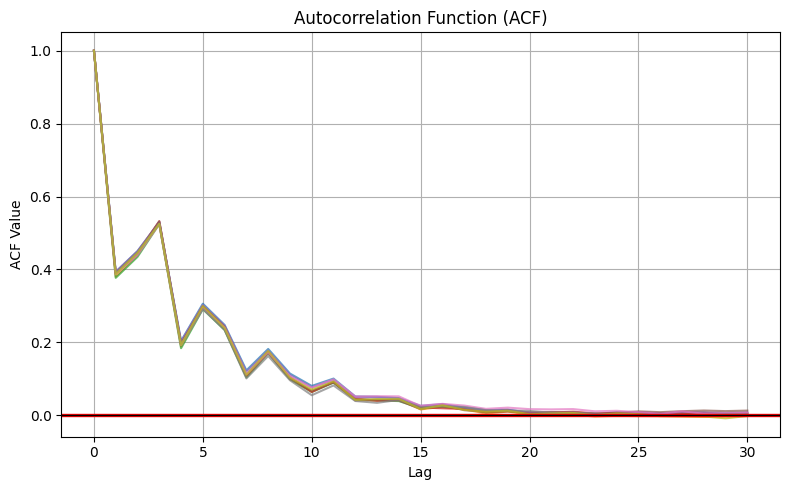

In [46]:
acf_summary = stat.auto_correlation_function(std_residuals, p=30)
stat.plot_acf(acf_summary, steps=data.shape[0])

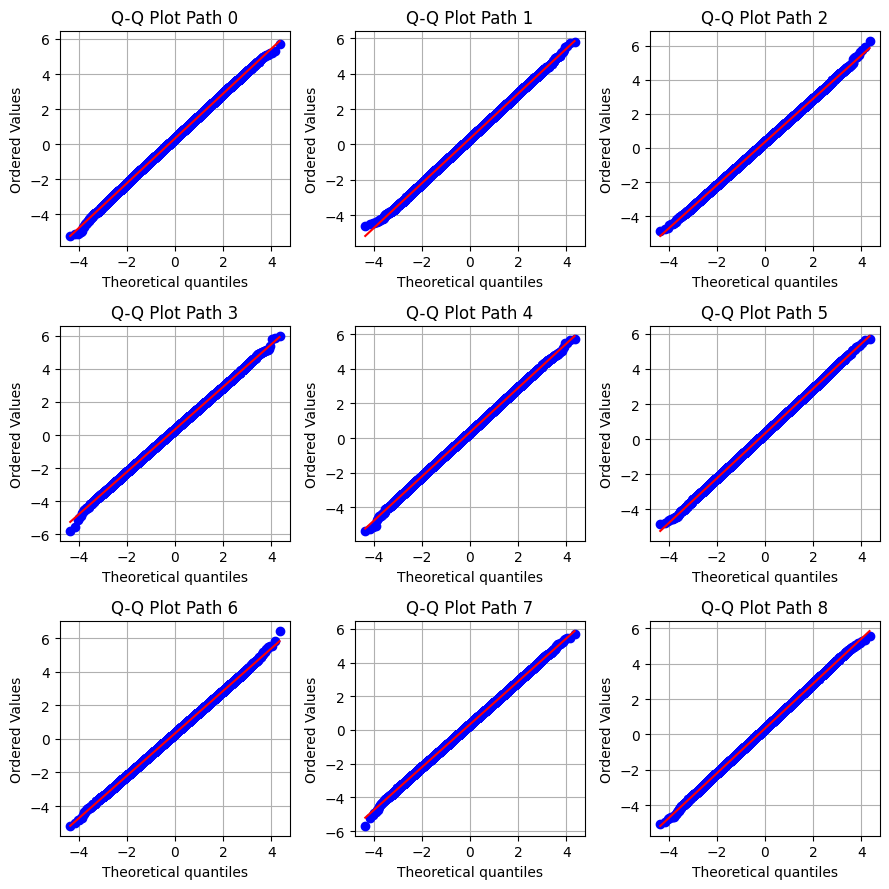

In [15]:
stat.qq_plot(data, dist='normal', ncols=3) 